In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F

import albumentations as A

import random
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import cv2

### Data Loading and Preprocessing

In [2]:
# Setting up our path variables
DATA_PATH = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data'
TRAIN_CSV = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/train.csv'
TRAIN_PATH = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/train'
TEST_PATH = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/test'
MASK_PATH = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/masks'
MASK_COMPILED_PATH = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/masks_compiled'

In [3]:
# Load training data into pandas dataframe
train = pd.read_csv(TRAIN_CSV)

In [4]:
# Verify the data has been loaded correctly
train.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [5]:
def show_images(num=9):
    """Display a number of images to check data"""
    plt.figure(figsize=(20,20))
    for i in range(num):
        plt.subplot(3, 3, i+1)
        img = cv2.imread(f'{TRAIN_PATH}/{train.iloc[i, 0]}.png')
        plt.imshow(img)

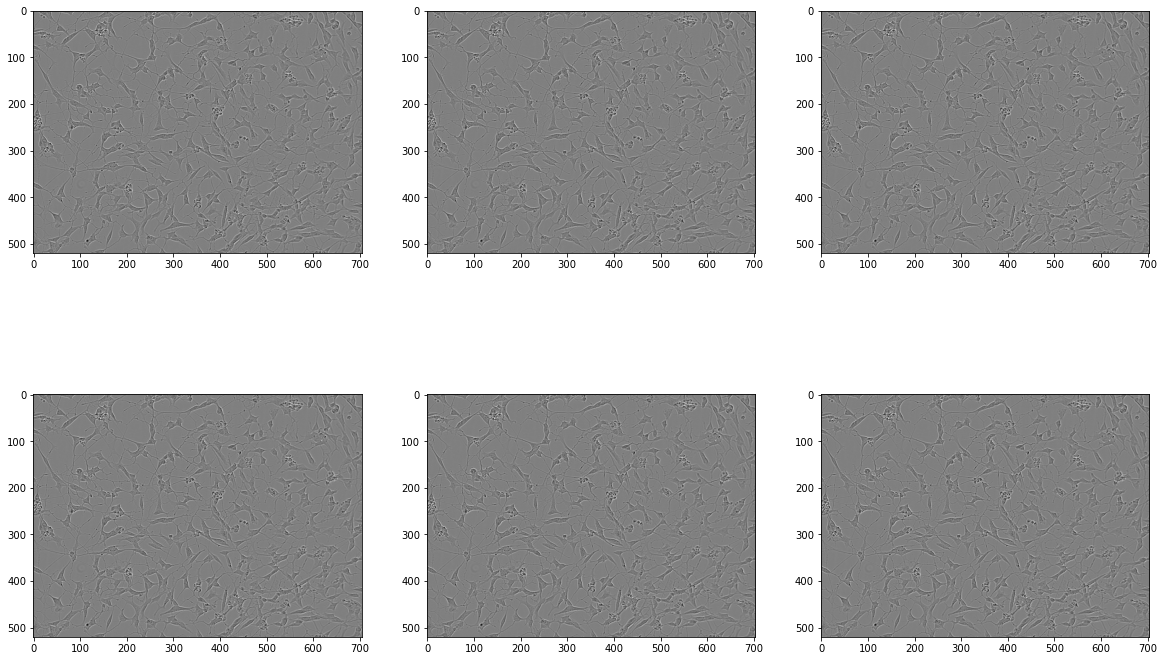

In [6]:
show_images(6)

In [7]:
print(f'Training Set Shape: {train.shape} - {train["id"].nunique()} \
Images - Memory Usage: {train.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Set Shape: (73585, 9) - 606 Images - Memory Usage: 5.05 MB


### Run Length Encoding and Decoding
* Annotations in train.csv are rle encoded
* Each instance must be decoded into a mask and saved
* Each mask corresponding to a certain image will be compiled into one mask and saved

In [8]:
def decode(rle, shape):
    """
    Takes an Run Length Encoded input and converts it into a numpy array
    rle: reun length encoded string
    shape: tuple of dimensions for the final array
    Returns: a numpy array where 1 corresponds to the annotation and 0 is nothing
    """
    rle_list = rle.split() # List of alternating pixel and RL values
    pixels = rle_list[::2]
    run_lengths = rle_list[1::2]
    # Convert to numpy arrays
    pixels_arr = np.asarray(pixels, dtype=int)
    lengths_np = np.asarray(run_lengths, dtype=int)
    # Calculate start and stop pixels for each rle pair
    pixel_start =  np.subtract(pixels_arr, int(1))
    pixel_stop = pixel_start + lengths_np
    # Create an empty numpy array to fill with mask
    mask = np.zeros(shape[0] * shape[1])
    for start, stop in zip(pixel_start, pixel_stop):
        mask[start:stop] = 255
    return mask.reshape(shape) # Numpy array


def encode(mask):
    """
    mask: the mask to perform run length encoding on
    Returns: a tuple (img_id, annotation)
    """
    raise NotImplementedError("Implement Encoding Function")

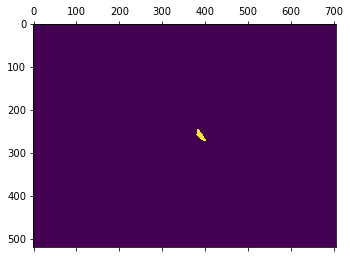

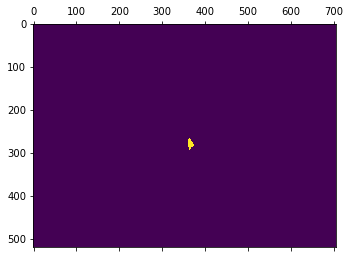

In [9]:
# Testing the rle decoder
X = decode("173567 3 174270 5 174974 5 175678 6 176382 7 177085 9 177789 9 178493 \
            10 179197 11 179901 12 180605 12 181308 14 182012 15 182716 15 183420 \
            16 184125 16 184831 15 185536 14 186241 14 186947 12 187651 13 188356 \
            12 189061 12 189767 10 190472 10 191177 9 191883 7 192589 5 193295 2 194000 1", (520, 704))
plt.matshow(X)
plt.show()
X = decode(train["annotation"][1], (520, 704))
plt.matshow(X)
plt.show()

### Applying decoding to training dataframe

In [10]:
train.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [11]:
# Loads each image into a data frame but I opted to just write them to my ssd with cv2.imwrite instead
def build_masks(df, shape=(520, 704)):
    """
    Takes the training dataframe and returns a dataframe of image masks
    df: training dataframe
    shape: the shape of the images; default=(704, 520)
    Returns a dataframe of the image masks
    """
    id_nums = df["id"].tolist()
    print(type(id_nums))
    annotations = df["annotation"].tolist()
    print(type(annotations))
    label_dict = {}
    for i, annotation in zip(id_nums, annotations):
        print(i)
        label_dict[i] = decode(annotation, shape=(520, 704))
    return pd.DataFrame(label_dict)


# Decode and store all annotations
def save_masks(df, shape=(520, 704)):
    """
    Takes the training dataframe, performs rle decoding on each instance,
    and writes each mask to the data directory with cv2.
    df: training dataframe
    shape: the shape of the images; default=(704, 520)
    """
    id_nums = df["id"].tolist()
    annotations = df["annotation"].tolist()
    path = DATA_PATH
    images = os.listdir(f'{path}/train')
    label_dict = {}
    inst_list = []
    count = 0
    for image in images:
        os.mkdir(f'{path}/masks/{image[0:12]}')
    for i, (img_id, annotation) in enumerate(zip(id_nums, annotations)):
        if (img_id not in inst_list):
            count = 0
            inst_list.append(img_id)
        img = decode(annotation, shape)
        if (i % 1000 == 0):
            print(f'Image: {img_id}\nInstance: {count}')
            plt.matshow(img)
            plt.show()
        cv2.imwrite(f'{path}/masks/{img_id}/{count}.png', img)
        count += 1


# Compile annotations into one mask for each image
def compile_masks(df, shape=(520, 704, 3)):
    """
    Takes the training data frame, and compiles all the saved
    masks corresponding to one training sample into one image.
    Saves the compiled masks and repeats for every image.
    df: training dataframe
    shape: shape of the images to save.
    """
    path = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data'
    images = os.listdir(f'{path}/train') 
    for i, image in enumerate(images):
        masks = np.zeros(shape)
        instances = os.listdir(f'{path}/masks/{image[0:12]}')
        for instance in instances:
            masks += cv2.imread(f'{path}/masks/{image[0:12]}/{instance}')
        masks = np.clip(masks, 0.0, 255.0)
        cv2.imwrite(f'{path}/masks_compiled/{image}', masks)
        if (i % 10 == 0):
            print(f'Image: {image[0:12]} ({i}/{len(images)})')
            plt.matshow(masks)
            plt.show()

In [12]:
# Uncomment to generate mask images
#save_masks(train)

In [13]:
# Uncomment to generate compiled mask images
#compile_masks(train)


<class 'numpy.ndarray'>
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]


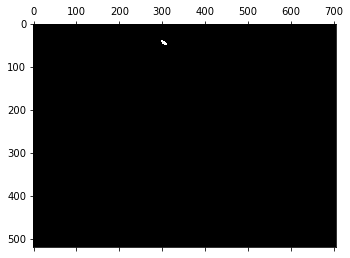

In [14]:
# Checking save_masks()
test_img = cv2.imread('C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/masks/0f08d640930b/10.png')
print(type(test_img))
print(test_img[0])
plt.matshow(test_img)
plt.show()

Mask Count: 606
['0030fd0e6378.png', '0140b3c8f445.png', '01ae5a43a2ab.png', '026b3c2c4b32.png', '029e5b3b89c7.png', '0323e81d23d9.png', '03b27b381a5f.png', '042c17cd9143.png', '042dc0e561a4.png', '04928f0866b0.png', '049f02e0f764.png', '04cd81dfb245.png', '053d61766edb.png', '05c61f0f46b7.png', '061b49d7dbbb.png', '06c5740c8b18.png', '0728b8f39241.png', '07e9ba109e34.png', '083b178bb184.png', '085eb8fec206.png', '08f52aa2add3.png', '097d60b2cf71.png', '0a6ecc5fe78a.png', '0ba181d412da.png', '0c5938ac5e3c.png']


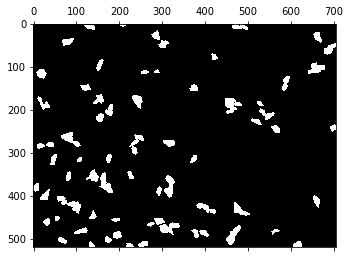

In [15]:
# Checking masks_compile()
mask_files = os.listdir('C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/masks_compiled')
test_img = cv2.imread('C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/masks_compiled/0f08d640930b.png')
print(f'Mask Count: {len(mask_files)}')
print(mask_files[0:25])
plt.matshow(test_img)
plt.show()

In [16]:
# Set up GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [17]:
# Building torch.util.data.Dataset class
class CellDataset(Dataset):
    def __init__(self, data=train, train=None, transform=None):
        # Load data
        self.data = data
        # Prepare the path variables
        self.BASE_PATH = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data'
        self.mask_paths = os.listdir(f'{self.BASE_PATH}/masks_compiled')
        self.train = train
        self.mask_paths_train, self.mask_paths_test = train_test_split(self.mask_paths, test_size=0.2, random_state=42)
        if self.train:
            self.mask_paths = self.mask_paths_train
        else:
            self.mask_paths = self.mask_paths_test
            
        # Register any transforms
        self.transforms = transform
            
    def __len__(self):
        return len(self.mask_paths)
    
    def __getitem__(self, index):
        # Read the specific image and its respective compiled mask
        mask = cv2.imread(f'{self.BASE_PATH}/masks_compiled/{self.mask_paths[index]}').astype(np.float32)
        mask[mask == 255.0] = 1.0
        img = cv2.imread(f'{self.BASE_PATH}/train/{str(self.mask_paths[index])[0:12]}.png')
        # Apply any transforms to both and return them
        if self.transforms:
            transformed = self.transforms(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        return self.mask_paths[index][0:12], img, mask


# I probably won't need this method because the PyTorch DataLoader default_collate method converts to torch tensors from np
class ToTensor:
    def __call__(self, sample):
        img, mask = sample
        return torch.from_numpy(img.astype(np.float32)), torch.from_numpy(mask.astype(np.float32)).to(device)
        

Mask Shape: (520, 704, 3)
Img Shape: (520, 704, 3)
Image ID: 1e7ac54a9422


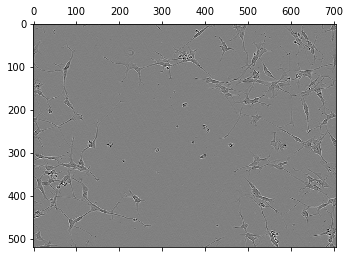

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mask ID: 1e7ac54a9422


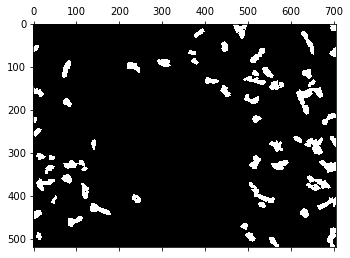

Combined:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


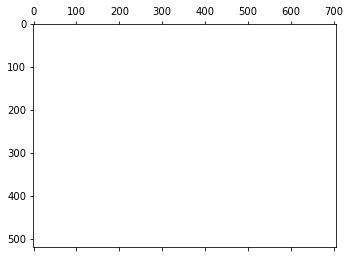

In [18]:
# Testing basic dataset functionality
cell_data = CellDataset(data=train, train=False)
img_id, img, mask = cell_data[2]
img = img.astype(int)
mask = mask.astype(int) * 255.0
print(f'Mask Shape: {mask.shape}\nImg Shape: {img.shape}')
print(f'Image ID: {img_id}')
plt.matshow(img)
plt.show()
print(f'Mask ID: {img_id}')
plt.matshow(mask)
plt.show()
print('Combined:')
plt.matshow(np.clip((img + mask), 0, 255)) # dtype is int; clip at 255
plt.show()

### Data Augmentations

Image Type: float32
Mask Type: float32

Image Shape: (512, 512, 3)
Mask Shape: (512, 512, 3)


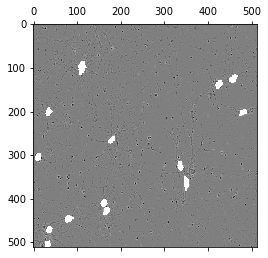

In [19]:
# Building a full list of transforms with Albumentations
transforms = A.Compose([A.Resize(512, 512),
                       A.Normalize(mean=(0.0, 0.0, 0.0), # 0.485, 0.456, 0.406
                                    std=(1.0, 1.0, 1.0),
                                    max_pixel_value=255.0,
                                    p=1.0),
                       A.HorizontalFlip(p=0.5),
                       A.VerticalFlip(p=0.5),
                       A.Rotate(limit=35, p=1.0)])
# Transformed dataset
cell_data = CellDataset(data=train, train=True, transform=transforms)
# Picking an arbitrary sample
img_id, img, mask = cell_data[2]
print(f'Image Type: {img.dtype}\nMask Type: {img.dtype}\n')
print(f'Image Shape: {img.shape}\nMask Shape: {mask.shape}')
masked = np.clip((mask + img), 0, 1) # The data has been normalized so now we are working with floats and clipping at 1.0
plt.matshow(masked)
plt.show()

### DataLoader Class

In [20]:
# Create the data loader
cell_dl = DataLoader(cell_data, batch_size=4, drop_last=True)
print(len(cell_dl))

121


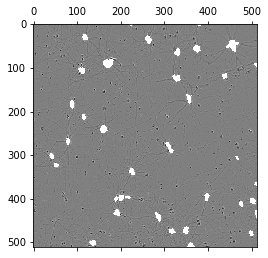

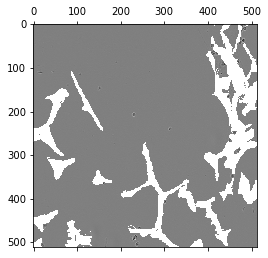

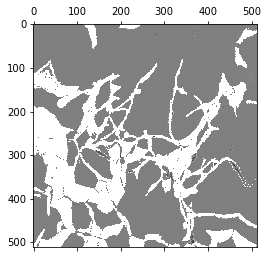

In [21]:
# Remember that data loader returns torch tensors because of default_collate(batch)
# Testing the DataLoader
test = iter(cell_dl)
img_id, img, mask = test.next()
img = img[0].numpy()
mask = mask[0].numpy()
masked = np.clip((mask + img), 0, 1)
plt.matshow(masked)

img_id, img, mask = test.next()
img = img[0].numpy()
mask = mask[0].numpy()
masked = np.clip((mask + img), 0, 1)
plt.matshow(masked)

img_id, img, mask = test.next()
img = img[0].numpy()
mask = mask[0].numpy()
masked = np.clip((mask + img), 0, 1)
plt.matshow(masked)

# Building a U-Net Model

Main Components:
* Contraction Path
    * Double Convolution
        * 3x3 unpadded
        * ReLU
    * Max Pooling
        * 2x2
        * Stride = 2
        * Downsampling
        * At each downsampling step, double the number of feature channels
* Expansion Path
    * Up - Convolution
        * 2x2
        * Upsampling of feature map
        * Halves the number of feature channels
    * Concatenation
        * With corresponding cropped feature map from contracting path
    * Double Convolution
        * 3x3
        * ReLU
    * Final Convolution
        * 1x1
        * Map each 64 component feature vector to the desired number of classes

* 23 Total Convolutional Layers
    

In [22]:
class DoubleConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2d, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1), # Padding? Paper calls for none
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1), # Padding? Paper calls for none
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    
    def forward(self, x):
        return self.conv1(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.downsampling = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(2, 2, padding=1)
        # Contraction Layer
        self.downsampling.append(DoubleConv2d(in_channels, 64))
        self.downsampling.append(DoubleConv2d(64, 128))
        self.downsampling.append(DoubleConv2d(128, 256))
        self.downsampling.append(DoubleConv2d(256, 512))
        self.downsample_final = DoubleConv2d(512, 1024)
        
        # Expansion Layer
        self.upsampling1 = nn.ConvTranspose2d(1024, 512, 2, 2) # 512 * 2 because of skip connection
        self.upsampling2 = DoubleConv2d(1024, 512)
        self.upsampling3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.upsampling4 = DoubleConv2d(512, 256)
        self.upsampling5 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.upsampling6 = DoubleConv2d(256, 128)
        self.upsampling7 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.upsampling8 = DoubleConv2d(128, 64)
        
        # Final 1x1 Convolution
        self.conv_final = nn.Conv2d(64, out_channels, 1)
        
    def forward(self, x):
        skips = []
        # Contraction Layer
        #print(f'Initial Shape: {x.shape}')
        for layer in self.downsampling:
            x = layer(x)
            #print(x.shape)
            skips.append(x)
            x = self.maxpool(x)
        x = self.downsample_final(x)
        
        # Expansion Layer - kinda messy looking maybe another module list is needed
        x = self.upsampling1(x)
        if x.shape != skips[3].shape:
            x = TF.resize(x, size=skips[3].shape[2:])
        x = self.upsampling2(torch.cat((skips[3], x), dim=1))
        x = self.upsampling3(x)
        if x.shape != skips[2].shape:
            x = TF.resize(x, size=skips[2].shape[2:])
        x = self.upsampling4(torch.cat((skips[2], x), dim=1))
        x = self.upsampling5(x)
        if x.shape != skips[1].shape:
            x = TF.resize(x, size=skips[1].shape[2:])
        x = self.upsampling6(torch.cat((skips[1], x), dim=1))
        x = self.upsampling7(x)
        if x.shape != skips[0].shape:
            x = TF.resize(x, size=skips[0].shape[2:])
        x = self.upsampling8(torch.cat((skips[0], x), dim=1))
        return self.conv_final(x)
        

### Loss Function
* Intersect over Union

In [31]:
# Ref: https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch/notebook
def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou


def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()
    

class IntersectionOverUnion(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, input, target):
        input = torch.sigmoid(input)
        loss = compute_iou(target, input)
        return loss.mean()

In [24]:
# Ref: https://www.kaggle.com/julian3833/sartorius-starter-baseline-torch-u-net
torch.cuda.empty_cache()
cell_dl = DataLoader(cell_data, batch_size=1, drop_last=True, shuffle=True)
n_batches = len(cell_dl)
LEARNING_RATE = 3e-4
EPOCHS = 10
criterion = MixedLoss(10.0, 2.0)
model = UNet(3, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Try SGD

for epoch in range(1, EPOCHS + 1):
    print(f"Starting epoch: {epoch} / {EPOCHS}")
    running_loss = 0.0
    optimizer.zero_grad()
    
    for i, batch in enumerate(cell_dl):
        # Predict
        img_id, images, masks = batch
        masks = torch.permute(masks.cuda(), (0, 3, 2, 1)).cuda()
        img = torch.permute(images, (0, 3, 2, 1)).cuda()
        output_temp = torch.zeros(img.shape).cuda()
        with torch.cuda.amp.autocast():
            outputs = model(img)
            output_temp[:][0:2] = outputs[0][0]
            #plt.matshow(torch.permute(output_temp, (0, 2, 3, 1)).detach().to('cpu')[0])
            #plt.show()
            outputs = output_temp
            loss = criterion(outputs, masks)
        print(f'Batch: {i}/{n_batches} Loss: {loss}')
        # Back prop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

    epoch_loss = running_loss / n_batches
    print(f"Epoch: {epoch} - Train Loss {epoch_loss:.4f}")
torch.save(model, f'{DATA_PATH}/model/model.pth')

Starting epoch: 1 / 10
Batch: 0/484 Loss: 5.821050643920898
Batch: 1/484 Loss: 5.022377014160156
Batch: 2/484 Loss: 6.031666278839111
Batch: 3/484 Loss: 2.343031644821167
Batch: 4/484 Loss: 5.541653633117676
Batch: 5/484 Loss: 5.895160675048828
Batch: 6/484 Loss: 2.5561680793762207
Batch: 7/484 Loss: 5.2723283767700195
Batch: 8/484 Loss: 5.167490005493164
Batch: 9/484 Loss: 3.693490743637085
Batch: 10/484 Loss: 2.185081958770752
Batch: 11/484 Loss: 3.124117851257324
Batch: 12/484 Loss: 3.892423152923584
Batch: 13/484 Loss: 2.390897274017334
Batch: 14/484 Loss: 3.214639186859131
Batch: 15/484 Loss: 2.1999244689941406
Batch: 16/484 Loss: 4.571017265319824
Batch: 17/484 Loss: 2.389690399169922
Batch: 18/484 Loss: 3.9307799339294434
Batch: 19/484 Loss: 3.7532191276550293
Batch: 20/484 Loss: 3.9060332775115967
Batch: 21/484 Loss: 2.05145001411438
Batch: 22/484 Loss: 3.8231403827667236
Batch: 23/484 Loss: 5.021256446838379
Batch: 24/484 Loss: 1.7813925743103027
Batch: 25/484 Loss: 3.52276444

Batch: 210/484 Loss: 2.3135783672332764
Batch: 211/484 Loss: 1.1817264556884766
Batch: 212/484 Loss: 1.6908352375030518
Batch: 213/484 Loss: 2.0533974170684814
Batch: 214/484 Loss: 2.521568775177002
Batch: 215/484 Loss: 1.7318108081817627
Batch: 216/484 Loss: 1.222790002822876
Batch: 217/484 Loss: 2.1125693321228027
Batch: 218/484 Loss: 1.926964282989502
Batch: 219/484 Loss: 1.3855671882629395
Batch: 220/484 Loss: 2.1525912284851074
Batch: 221/484 Loss: 2.438214063644409
Batch: 222/484 Loss: 1.4982367753982544
Batch: 223/484 Loss: 1.708530068397522
Batch: 224/484 Loss: 1.803910255432129
Batch: 225/484 Loss: 1.2289061546325684
Batch: 226/484 Loss: 3.1806769371032715
Batch: 227/484 Loss: 2.3954572677612305
Batch: 228/484 Loss: 2.6341443061828613
Batch: 229/484 Loss: 1.955101728439331
Batch: 230/484 Loss: 1.2401142120361328
Batch: 231/484 Loss: 1.4897451400756836
Batch: 232/484 Loss: 1.6408511400222778
Batch: 233/484 Loss: 1.4269235134124756
Batch: 234/484 Loss: 1.9486271142959595
Batch: 

Batch: 417/484 Loss: 2.504857301712036
Batch: 418/484 Loss: 3.2209243774414062
Batch: 419/484 Loss: 1.4395653009414673
Batch: 420/484 Loss: 1.0765836238861084
Batch: 421/484 Loss: 2.1290335655212402
Batch: 422/484 Loss: 1.8640241622924805
Batch: 423/484 Loss: 2.976747751235962
Batch: 424/484 Loss: 2.050419569015503
Batch: 425/484 Loss: 2.039240598678589
Batch: 426/484 Loss: 1.4211885929107666
Batch: 427/484 Loss: 1.2688230276107788
Batch: 428/484 Loss: 1.3576433658599854
Batch: 429/484 Loss: 1.8248279094696045
Batch: 430/484 Loss: 1.4981749057769775
Batch: 431/484 Loss: 1.447190761566162
Batch: 432/484 Loss: 2.4601147174835205
Batch: 433/484 Loss: 1.9873758554458618
Batch: 434/484 Loss: 1.6833012104034424
Batch: 435/484 Loss: 1.4579908847808838
Batch: 436/484 Loss: 1.2949697971343994
Batch: 437/484 Loss: 0.9996808171272278
Batch: 438/484 Loss: 2.060715913772583
Batch: 439/484 Loss: 1.1137816905975342
Batch: 440/484 Loss: 1.810603141784668
Batch: 441/484 Loss: 1.537452220916748
Batch: 4

Batch: 142/484 Loss: 1.0946580171585083
Batch: 143/484 Loss: 0.9558528661727905
Batch: 144/484 Loss: 1.2674975395202637
Batch: 145/484 Loss: 1.6844894886016846
Batch: 146/484 Loss: 1.7661933898925781
Batch: 147/484 Loss: 1.411010980606079
Batch: 148/484 Loss: 0.9015529155731201
Batch: 149/484 Loss: 1.2187577486038208
Batch: 150/484 Loss: 1.0772759914398193
Batch: 151/484 Loss: 1.2389869689941406
Batch: 152/484 Loss: 1.2933061122894287
Batch: 153/484 Loss: 1.313169240951538
Batch: 154/484 Loss: 1.3841679096221924
Batch: 155/484 Loss: 2.373412609100342
Batch: 156/484 Loss: 1.690679669380188
Batch: 157/484 Loss: 1.7920414209365845
Batch: 158/484 Loss: 1.1698741912841797
Batch: 159/484 Loss: 1.1037299633026123
Batch: 160/484 Loss: 1.720883846282959
Batch: 161/484 Loss: 1.468322515487671
Batch: 162/484 Loss: 0.9358460903167725
Batch: 163/484 Loss: 1.6305568218231201
Batch: 164/484 Loss: 2.0580623149871826
Batch: 165/484 Loss: 0.7566986680030823
Batch: 166/484 Loss: 1.3015854358673096
Batch:

Batch: 349/484 Loss: 0.9300709962844849
Batch: 350/484 Loss: 1.3075475692749023
Batch: 351/484 Loss: 1.5430690050125122
Batch: 352/484 Loss: 1.5060948133468628
Batch: 353/484 Loss: 1.1075513362884521
Batch: 354/484 Loss: 1.2063148021697998
Batch: 355/484 Loss: 1.7748523950576782
Batch: 356/484 Loss: 1.5469434261322021
Batch: 357/484 Loss: 1.7146461009979248
Batch: 358/484 Loss: 1.5922331809997559
Batch: 359/484 Loss: 1.1586170196533203
Batch: 360/484 Loss: 1.1864181756973267
Batch: 361/484 Loss: 1.0521706342697144
Batch: 362/484 Loss: 1.2290318012237549
Batch: 363/484 Loss: 1.4586676359176636
Batch: 364/484 Loss: 1.3164637088775635
Batch: 365/484 Loss: 1.3326444625854492
Batch: 366/484 Loss: 1.2001395225524902
Batch: 367/484 Loss: 1.2382938861846924
Batch: 368/484 Loss: 1.1530925035476685
Batch: 369/484 Loss: 1.369795799255371
Batch: 370/484 Loss: 1.5012065172195435
Batch: 371/484 Loss: 1.5904675722122192
Batch: 372/484 Loss: 1.117112159729004
Batch: 373/484 Loss: 1.0881654024124146
Ba

Batch: 72/484 Loss: 0.9200810194015503
Batch: 73/484 Loss: 0.794687807559967
Batch: 74/484 Loss: 1.5187335014343262
Batch: 75/484 Loss: 0.9998172521591187
Batch: 76/484 Loss: 1.0041632652282715
Batch: 77/484 Loss: 1.7177342176437378
Batch: 78/484 Loss: 1.0001156330108643
Batch: 79/484 Loss: 1.5947660207748413
Batch: 80/484 Loss: 1.1543340682983398
Batch: 81/484 Loss: 1.6871483325958252
Batch: 82/484 Loss: 1.4933382272720337
Batch: 83/484 Loss: 0.9126070141792297
Batch: 84/484 Loss: 1.3053927421569824
Batch: 85/484 Loss: 1.517153024673462
Batch: 86/484 Loss: 0.7293087244033813
Batch: 87/484 Loss: 1.285354495048523
Batch: 88/484 Loss: 0.8681650161743164
Batch: 89/484 Loss: 2.6617722511291504
Batch: 90/484 Loss: 1.2940847873687744
Batch: 91/484 Loss: 1.171622633934021
Batch: 92/484 Loss: 0.977779746055603
Batch: 93/484 Loss: 1.359005331993103
Batch: 94/484 Loss: 0.9581446051597595
Batch: 95/484 Loss: 1.3504786491394043
Batch: 96/484 Loss: 0.6845192909240723
Batch: 97/484 Loss: 1.482739090

Batch: 279/484 Loss: 0.8459163308143616
Batch: 280/484 Loss: 1.2588778734207153
Batch: 281/484 Loss: 0.8010324239730835
Batch: 282/484 Loss: 1.507776141166687
Batch: 283/484 Loss: 0.7495501637458801
Batch: 284/484 Loss: 0.7948420643806458
Batch: 285/484 Loss: 0.9135230779647827
Batch: 286/484 Loss: 2.3177900314331055
Batch: 287/484 Loss: 2.865056276321411
Batch: 288/484 Loss: 0.7788918018341064
Batch: 289/484 Loss: 1.329479455947876
Batch: 290/484 Loss: 0.9341641664505005
Batch: 291/484 Loss: 1.1044468879699707
Batch: 292/484 Loss: 1.0614557266235352
Batch: 293/484 Loss: 2.6070055961608887
Batch: 294/484 Loss: 0.8104785084724426
Batch: 295/484 Loss: 0.8003463745117188
Batch: 296/484 Loss: 1.5569456815719604
Batch: 297/484 Loss: 3.3236026763916016
Batch: 298/484 Loss: 0.9154952168464661
Batch: 299/484 Loss: 1.0226298570632935
Batch: 300/484 Loss: 1.6437270641326904
Batch: 301/484 Loss: 1.6568663120269775
Batch: 302/484 Loss: 0.5973386764526367
Batch: 303/484 Loss: 1.209368109703064
Batc

Batch: 0/484 Loss: 1.3085815906524658
Batch: 1/484 Loss: 0.6816480755805969
Batch: 2/484 Loss: 2.7617459297180176
Batch: 3/484 Loss: 3.9028706550598145
Batch: 4/484 Loss: 0.6538327932357788
Batch: 5/484 Loss: 0.8071129322052002
Batch: 6/484 Loss: 1.0795527696609497
Batch: 7/484 Loss: 1.2106807231903076
Batch: 8/484 Loss: 1.5057711601257324
Batch: 9/484 Loss: 0.8369163870811462
Batch: 10/484 Loss: 1.3846237659454346
Batch: 11/484 Loss: 0.8374816179275513
Batch: 12/484 Loss: 0.7605399489402771
Batch: 13/484 Loss: 0.8782971501350403
Batch: 14/484 Loss: 1.2902873754501343
Batch: 15/484 Loss: 0.7659415006637573
Batch: 16/484 Loss: 1.077888011932373
Batch: 17/484 Loss: 1.133262038230896
Batch: 18/484 Loss: 1.1133204698562622
Batch: 19/484 Loss: 1.2873387336730957
Batch: 20/484 Loss: 1.2287144660949707
Batch: 21/484 Loss: 1.2964379787445068
Batch: 22/484 Loss: 0.9856521487236023
Batch: 23/484 Loss: 0.9602604508399963
Batch: 24/484 Loss: 5.018671035766602
Batch: 25/484 Loss: 0.6097761988639832

Batch: 209/484 Loss: 1.4339509010314941
Batch: 210/484 Loss: 0.7231848835945129
Batch: 211/484 Loss: 1.613046646118164
Batch: 212/484 Loss: 1.0551650524139404
Batch: 213/484 Loss: 0.8565987944602966
Batch: 214/484 Loss: 1.12655770778656
Batch: 215/484 Loss: 0.7727672457695007
Batch: 216/484 Loss: 1.8267457485198975
Batch: 217/484 Loss: 1.1345229148864746
Batch: 218/484 Loss: 1.3154525756835938
Batch: 219/484 Loss: 0.925976037979126
Batch: 220/484 Loss: 1.4767606258392334
Batch: 221/484 Loss: 0.8580911159515381
Batch: 222/484 Loss: 1.7660908699035645
Batch: 223/484 Loss: 1.1162399053573608
Batch: 224/484 Loss: 0.6116639971733093
Batch: 225/484 Loss: 0.7081443071365356
Batch: 226/484 Loss: 1.0368049144744873
Batch: 227/484 Loss: 0.5596069693565369
Batch: 228/484 Loss: 1.0809781551361084
Batch: 229/484 Loss: 1.2543057203292847
Batch: 230/484 Loss: 1.1363590955734253
Batch: 231/484 Loss: 0.6444847583770752
Batch: 232/484 Loss: 0.9515429735183716
Batch: 233/484 Loss: 1.4915114641189575
Batc

Batch: 415/484 Loss: 1.3143231868743896
Batch: 416/484 Loss: 1.2989733219146729
Batch: 417/484 Loss: 0.4048762321472168
Batch: 418/484 Loss: 1.5053929090499878
Batch: 419/484 Loss: 1.513550877571106
Batch: 420/484 Loss: 18.753389358520508
Batch: 421/484 Loss: 1.1240215301513672
Batch: 422/484 Loss: 1.9958114624023438
Batch: 423/484 Loss: 2.379279613494873
Batch: 424/484 Loss: 1.1948482990264893
Batch: 425/484 Loss: 3.051668643951416
Batch: 426/484 Loss: 2.20027494430542
Batch: 427/484 Loss: 2.1315438747406006
Batch: 428/484 Loss: 1.2362087965011597
Batch: 429/484 Loss: 2.218155860900879
Batch: 430/484 Loss: 1.5349493026733398
Batch: 431/484 Loss: 2.2631120681762695
Batch: 432/484 Loss: 1.5244370698928833
Batch: 433/484 Loss: 1.8946689367294312
Batch: 434/484 Loss: 1.7036035060882568
Batch: 435/484 Loss: 3.8805153369903564
Batch: 436/484 Loss: 1.8866915702819824
Batch: 437/484 Loss: 10.814669609069824
Batch: 438/484 Loss: 1.5257816314697266
Batch: 439/484 Loss: 2.6010799407958984
Batch:

Batch: 140/484 Loss: 1.499131679534912
Batch: 141/484 Loss: 1.332718014717102
Batch: 142/484 Loss: 1.293864369392395
Batch: 143/484 Loss: 0.9900354146957397
Batch: 144/484 Loss: 0.8592542409896851
Batch: 145/484 Loss: 1.3757967948913574
Batch: 146/484 Loss: 0.808413028717041
Batch: 147/484 Loss: 1.3378422260284424
Batch: 148/484 Loss: 1.3297001123428345
Batch: 149/484 Loss: 0.5667486190795898
Batch: 150/484 Loss: 0.6474862098693848
Batch: 151/484 Loss: 4.645512580871582
Batch: 152/484 Loss: 1.1968820095062256
Batch: 153/484 Loss: 0.6985385417938232
Batch: 154/484 Loss: 1.3779571056365967
Batch: 155/484 Loss: 1.3919984102249146
Batch: 156/484 Loss: 1.8407822847366333
Batch: 157/484 Loss: 1.6716259717941284
Batch: 158/484 Loss: 1.4860279560089111
Batch: 159/484 Loss: 0.9853770136833191
Batch: 160/484 Loss: 1.380205750465393
Batch: 161/484 Loss: 0.9616817235946655
Batch: 162/484 Loss: 1.2335047721862793
Batch: 163/484 Loss: 2.4889419078826904
Batch: 164/484 Loss: 1.6404519081115723
Batch:

Batch: 346/484 Loss: 1.1825026273727417
Batch: 347/484 Loss: 1.2645704746246338
Batch: 348/484 Loss: 5.5569071769714355
Batch: 349/484 Loss: 2.2527658939361572
Batch: 350/484 Loss: 1.2280371189117432
Batch: 351/484 Loss: 0.9517673254013062
Batch: 352/484 Loss: 0.8976073861122131
Batch: 353/484 Loss: 1.6553592681884766
Batch: 354/484 Loss: 1.5690884590148926
Batch: 355/484 Loss: 1.167324185371399
Batch: 356/484 Loss: 1.3906663656234741
Batch: 357/484 Loss: 1.1861079931259155
Batch: 358/484 Loss: 0.911225438117981
Batch: 359/484 Loss: 1.8502230644226074
Batch: 360/484 Loss: 0.7858859300613403
Batch: 361/484 Loss: 1.0347216129302979
Batch: 362/484 Loss: 1.3513948917388916
Batch: 363/484 Loss: 0.7014809846878052
Batch: 364/484 Loss: 0.8953753709793091
Batch: 365/484 Loss: 1.5442594289779663
Batch: 366/484 Loss: 1.303439974784851
Batch: 367/484 Loss: 1.316025972366333
Batch: 368/484 Loss: 1.114051342010498
Batch: 369/484 Loss: 0.8997660875320435
Batch: 370/484 Loss: 1.0970667600631714
Batch

Batch: 69/484 Loss: 0.6329106092453003
Batch: 70/484 Loss: 0.6172182559967041
Batch: 71/484 Loss: 4.726485252380371
Batch: 72/484 Loss: 1.4136666059494019
Batch: 73/484 Loss: 1.4482494592666626
Batch: 74/484 Loss: 0.5394308567047119
Batch: 75/484 Loss: 0.4704414904117584
Batch: 76/484 Loss: 1.37729012966156
Batch: 77/484 Loss: 1.3875033855438232
Batch: 78/484 Loss: 1.2005980014801025
Batch: 79/484 Loss: 0.47281384468078613
Batch: 80/484 Loss: 1.7501070499420166
Batch: 81/484 Loss: 2.608774185180664
Batch: 82/484 Loss: 0.8999488353729248
Batch: 83/484 Loss: 1.1712956428527832
Batch: 84/484 Loss: 1.7526088953018188
Batch: 85/484 Loss: 1.3314390182495117
Batch: 86/484 Loss: 1.2087793350219727
Batch: 87/484 Loss: 1.5260275602340698
Batch: 88/484 Loss: 0.5557940602302551
Batch: 89/484 Loss: 1.0639829635620117
Batch: 90/484 Loss: 0.9201498031616211
Batch: 91/484 Loss: 1.264457106590271
Batch: 92/484 Loss: 0.7714806795120239
Batch: 93/484 Loss: 1.2209962606430054
Batch: 94/484 Loss: 0.9978328

Batch: 276/484 Loss: 0.7452040910720825
Batch: 277/484 Loss: 2.507479429244995
Batch: 278/484 Loss: 0.6378322839736938
Batch: 279/484 Loss: 0.46863895654678345
Batch: 280/484 Loss: 0.9594235420227051
Batch: 281/484 Loss: 0.5587075352668762
Batch: 282/484 Loss: 0.693212628364563
Batch: 283/484 Loss: 0.9360580444335938
Batch: 284/484 Loss: 1.1863420009613037
Batch: 285/484 Loss: 1.7412848472595215
Batch: 286/484 Loss: 0.8750110864639282
Batch: 287/484 Loss: 1.1853307485580444
Batch: 288/484 Loss: 1.6369389295578003
Batch: 289/484 Loss: 0.8743849396705627
Batch: 290/484 Loss: 2.422544479370117
Batch: 291/484 Loss: 1.4844090938568115
Batch: 292/484 Loss: 1.0546064376831055
Batch: 293/484 Loss: 0.9462286829948425
Batch: 294/484 Loss: 0.8144509792327881
Batch: 295/484 Loss: 1.6045907735824585
Batch: 296/484 Loss: 0.8540764451026917
Batch: 297/484 Loss: 0.8114650845527649
Batch: 298/484 Loss: 1.2466466426849365
Batch: 299/484 Loss: 0.5771556496620178
Batch: 300/484 Loss: 0.6469187140464783
Ba

Batch: 482/484 Loss: 0.36297866702079773
Batch: 483/484 Loss: 0.5100756883621216
Epoch: 6 - Train Loss 1.0393
Starting epoch: 7 / 10
Batch: 0/484 Loss: 0.4721418023109436
Batch: 1/484 Loss: 0.7595073580741882
Batch: 2/484 Loss: 1.1606595516204834
Batch: 3/484 Loss: 1.2018239498138428
Batch: 4/484 Loss: 0.4358487129211426
Batch: 5/484 Loss: 1.1968302726745605
Batch: 6/484 Loss: 0.9679609537124634
Batch: 7/484 Loss: 1.5714325904846191
Batch: 8/484 Loss: 1.0800009965896606
Batch: 9/484 Loss: 0.7617223858833313
Batch: 10/484 Loss: 0.7346129417419434
Batch: 11/484 Loss: 0.7928987741470337
Batch: 12/484 Loss: 0.4850162863731384
Batch: 13/484 Loss: 1.0139085054397583
Batch: 14/484 Loss: 2.9002721309661865
Batch: 15/484 Loss: 1.0904710292816162
Batch: 16/484 Loss: 1.465131402015686
Batch: 17/484 Loss: 0.46503227949142456
Batch: 18/484 Loss: 1.2665140628814697
Batch: 19/484 Loss: 1.7448736429214478
Batch: 20/484 Loss: 0.41910916566848755
Batch: 21/484 Loss: 1.2545641660690308
Batch: 22/484 Loss

Batch: 205/484 Loss: 1.3455256223678589
Batch: 206/484 Loss: 1.4630560874938965
Batch: 207/484 Loss: 0.6259793043136597
Batch: 208/484 Loss: 1.324448585510254
Batch: 209/484 Loss: 2.082845687866211
Batch: 210/484 Loss: 1.1460881233215332
Batch: 211/484 Loss: 0.37239158153533936
Batch: 212/484 Loss: 1.1855897903442383
Batch: 213/484 Loss: 0.7592606544494629
Batch: 214/484 Loss: 0.49067288637161255
Batch: 215/484 Loss: 0.37177181243896484
Batch: 216/484 Loss: 0.42697274684906006
Batch: 217/484 Loss: 1.3910832405090332
Batch: 218/484 Loss: 1.3964447975158691
Batch: 219/484 Loss: 0.7601847648620605
Batch: 220/484 Loss: 0.5654721260070801
Batch: 221/484 Loss: 0.5388224124908447
Batch: 222/484 Loss: 0.5046175122261047
Batch: 223/484 Loss: 0.6028842329978943
Batch: 224/484 Loss: 0.6475369334220886
Batch: 225/484 Loss: 0.5072578191757202
Batch: 226/484 Loss: 1.2560148239135742
Batch: 227/484 Loss: 1.3089840412139893
Batch: 228/484 Loss: 1.043651819229126
Batch: 229/484 Loss: 0.5922906398773193

Batch: 410/484 Loss: 1.1276919841766357
Batch: 411/484 Loss: 1.2332539558410645
Batch: 412/484 Loss: 1.2523529529571533
Batch: 413/484 Loss: 1.1170622110366821
Batch: 414/484 Loss: 0.5281121730804443
Batch: 415/484 Loss: 0.455486536026001
Batch: 416/484 Loss: 1.5763297080993652
Batch: 417/484 Loss: 1.7698123455047607
Batch: 418/484 Loss: 0.45623576641082764
Batch: 419/484 Loss: 0.8365486860275269
Batch: 420/484 Loss: 0.40823715925216675
Batch: 421/484 Loss: 6.202335834503174
Batch: 422/484 Loss: 0.47519034147262573
Batch: 423/484 Loss: 0.9355238676071167
Batch: 424/484 Loss: 0.4399159550666809
Batch: 425/484 Loss: 0.48902273178100586
Batch: 426/484 Loss: 2.403932809829712
Batch: 427/484 Loss: 1.2751250267028809
Batch: 428/484 Loss: 1.242832899093628
Batch: 429/484 Loss: 0.4839026927947998
Batch: 430/484 Loss: 0.5351772904396057
Batch: 431/484 Loss: 0.36668485403060913
Batch: 432/484 Loss: 0.5240775346755981
Batch: 433/484 Loss: 1.248757004737854
Batch: 434/484 Loss: 1.1221803426742554


Batch: 133/484 Loss: 0.35046306252479553
Batch: 134/484 Loss: 0.7088743448257446
Batch: 135/484 Loss: 0.7915515899658203
Batch: 136/484 Loss: 0.46631860733032227
Batch: 137/484 Loss: 0.8147268891334534
Batch: 138/484 Loss: 0.8307168483734131
Batch: 139/484 Loss: 0.5146600604057312
Batch: 140/484 Loss: 0.6532160043716431
Batch: 141/484 Loss: 0.7868236303329468
Batch: 142/484 Loss: 0.5047667622566223
Batch: 143/484 Loss: 0.4150111973285675
Batch: 144/484 Loss: 0.29415276646614075
Batch: 145/484 Loss: 0.5736322402954102
Batch: 146/484 Loss: 1.160111665725708
Batch: 147/484 Loss: 0.696970522403717
Batch: 148/484 Loss: 0.5625724792480469
Batch: 149/484 Loss: 0.8390712738037109
Batch: 150/484 Loss: 1.7491791248321533
Batch: 151/484 Loss: 0.4803062379360199
Batch: 152/484 Loss: 0.43770819902420044
Batch: 153/484 Loss: 0.41769081354141235
Batch: 154/484 Loss: 1.3647608757019043
Batch: 155/484 Loss: 1.3125636577606201
Batch: 156/484 Loss: 1.0607645511627197
Batch: 157/484 Loss: 0.53085404634475

Batch: 339/484 Loss: 1.2767163515090942
Batch: 340/484 Loss: 1.849001169204712
Batch: 341/484 Loss: 0.345050573348999
Batch: 342/484 Loss: 1.0212926864624023
Batch: 343/484 Loss: 1.1365118026733398
Batch: 344/484 Loss: 1.162369728088379
Batch: 345/484 Loss: 1.0094614028930664
Batch: 346/484 Loss: 1.3537185192108154
Batch: 347/484 Loss: 1.4555578231811523
Batch: 348/484 Loss: 1.1746147871017456
Batch: 349/484 Loss: 1.1425082683563232
Batch: 350/484 Loss: 0.41053733229637146
Batch: 351/484 Loss: 5.951861381530762
Batch: 352/484 Loss: 1.132077693939209
Batch: 353/484 Loss: 1.0866093635559082
Batch: 354/484 Loss: 0.9308483600616455
Batch: 355/484 Loss: 1.2176545858383179
Batch: 356/484 Loss: 1.2622675895690918
Batch: 357/484 Loss: 0.6729259490966797
Batch: 358/484 Loss: 0.6225274205207825
Batch: 359/484 Loss: 1.3086676597595215
Batch: 360/484 Loss: 1.0159261226654053
Batch: 361/484 Loss: 0.45340684056282043
Batch: 362/484 Loss: 0.33712559938430786
Batch: 363/484 Loss: 1.033135175704956
Bat

Batch: 61/484 Loss: 1.3433704376220703
Batch: 62/484 Loss: 0.6339489221572876
Batch: 63/484 Loss: 2.4865541458129883
Batch: 64/484 Loss: 0.4433267116546631
Batch: 65/484 Loss: 3.2834575176239014
Batch: 66/484 Loss: 0.6745304465293884
Batch: 67/484 Loss: 0.9763692021369934
Batch: 68/484 Loss: 0.9594340324401855
Batch: 69/484 Loss: 0.6263918876647949
Batch: 70/484 Loss: 2.2190418243408203
Batch: 71/484 Loss: 0.7707825899124146
Batch: 72/484 Loss: 1.2099082469940186
Batch: 73/484 Loss: 0.7408193349838257
Batch: 74/484 Loss: 0.8411800861358643
Batch: 75/484 Loss: 0.7793747782707214
Batch: 76/484 Loss: 0.8593415021896362
Batch: 77/484 Loss: 1.3135426044464111
Batch: 78/484 Loss: 1.8005194664001465
Batch: 79/484 Loss: 0.5652655363082886
Batch: 80/484 Loss: 0.8240923881530762
Batch: 81/484 Loss: 1.2978308200836182
Batch: 82/484 Loss: 1.1047155857086182
Batch: 83/484 Loss: 2.0424957275390625
Batch: 84/484 Loss: 1.7190035581588745
Batch: 85/484 Loss: 0.4792943596839905
Batch: 86/484 Loss: 1.311

Batch: 268/484 Loss: 1.0223582983016968
Batch: 269/484 Loss: 0.28681689500808716
Batch: 270/484 Loss: 0.7486274242401123
Batch: 271/484 Loss: 0.5247829556465149
Batch: 272/484 Loss: 1.1533308029174805
Batch: 273/484 Loss: 0.6942052841186523
Batch: 274/484 Loss: 0.4161050021648407
Batch: 275/484 Loss: 0.9425867795944214
Batch: 276/484 Loss: 0.43197914958000183
Batch: 277/484 Loss: 0.6928811073303223
Batch: 278/484 Loss: 0.5529237985610962
Batch: 279/484 Loss: 1.3023508787155151
Batch: 280/484 Loss: 1.2278400659561157
Batch: 281/484 Loss: 0.5537055134773254
Batch: 282/484 Loss: 1.3070942163467407
Batch: 283/484 Loss: 0.6352002620697021
Batch: 284/484 Loss: 0.952064037322998
Batch: 285/484 Loss: 1.0520005226135254
Batch: 286/484 Loss: 0.4647941291332245
Batch: 287/484 Loss: 0.7969343662261963
Batch: 288/484 Loss: 0.967151939868927
Batch: 289/484 Loss: 0.4642890691757202
Batch: 290/484 Loss: 1.3687657117843628
Batch: 291/484 Loss: 0.3876796066761017
Batch: 292/484 Loss: 0.6142082214355469


Batch: 474/484 Loss: 0.6017388105392456
Batch: 475/484 Loss: 1.2046089172363281
Batch: 476/484 Loss: 1.2966845035552979
Batch: 477/484 Loss: 1.4428335428237915
Batch: 478/484 Loss: 2.045076847076416
Batch: 479/484 Loss: 1.0028538703918457
Batch: 480/484 Loss: 1.1544113159179688
Batch: 481/484 Loss: 1.0853114128112793
Batch: 482/484 Loss: 0.9303215742111206
Batch: 483/484 Loss: 1.051246166229248
Epoch: 9 - Train Loss 1.0059
Starting epoch: 10 / 10
Batch: 0/484 Loss: 1.0121181011199951
Batch: 1/484 Loss: 0.7185434103012085
Batch: 2/484 Loss: 0.9304120540618896
Batch: 3/484 Loss: 1.1976686716079712
Batch: 4/484 Loss: 1.6758627891540527
Batch: 5/484 Loss: 2.2153913974761963
Batch: 6/484 Loss: 0.6492525339126587
Batch: 7/484 Loss: 0.6809953451156616
Batch: 8/484 Loss: 1.5127164125442505
Batch: 9/484 Loss: 0.6523866653442383
Batch: 10/484 Loss: 2.1063766479492188
Batch: 11/484 Loss: 0.7475205063819885
Batch: 12/484 Loss: 1.3655271530151367
Batch: 13/484 Loss: 0.7578760385513306
Batch: 14/484

Batch: 198/484 Loss: 0.7981575131416321
Batch: 199/484 Loss: 1.444655418395996
Batch: 200/484 Loss: 0.8173906803131104
Batch: 201/484 Loss: 0.7157010436058044
Batch: 202/484 Loss: 0.6718662977218628
Batch: 203/484 Loss: 0.5047285556793213
Batch: 204/484 Loss: 1.2176975011825562
Batch: 205/484 Loss: 1.2865917682647705
Batch: 206/484 Loss: 0.37261152267456055
Batch: 207/484 Loss: 0.44440513849258423
Batch: 208/484 Loss: 1.3476537466049194
Batch: 209/484 Loss: 0.430122435092926
Batch: 210/484 Loss: 1.119875192642212
Batch: 211/484 Loss: 1.2784857749938965
Batch: 212/484 Loss: 0.6367740631103516
Batch: 213/484 Loss: 0.7651396989822388
Batch: 214/484 Loss: 1.2211649417877197
Batch: 215/484 Loss: 0.49723994731903076
Batch: 216/484 Loss: 0.8704711198806763
Batch: 217/484 Loss: 0.3364379405975342
Batch: 218/484 Loss: 1.18357253074646
Batch: 219/484 Loss: 0.9418798685073853
Batch: 220/484 Loss: 0.49252933263778687
Batch: 221/484 Loss: 1.4426512718200684
Batch: 222/484 Loss: 0.4988130033016205
B

Batch: 404/484 Loss: 0.4160730540752411
Batch: 405/484 Loss: 0.8986417651176453
Batch: 406/484 Loss: 1.1841588020324707
Batch: 407/484 Loss: 1.13517427444458
Batch: 408/484 Loss: 0.6922193765640259
Batch: 409/484 Loss: 0.8986116051673889
Batch: 410/484 Loss: 0.39808809757232666
Batch: 411/484 Loss: 0.3780333697795868
Batch: 412/484 Loss: 0.6653984785079956
Batch: 413/484 Loss: 0.39989086985588074
Batch: 414/484 Loss: 1.1464154720306396
Batch: 415/484 Loss: 1.047060489654541
Batch: 416/484 Loss: 0.4471955895423889
Batch: 417/484 Loss: 1.4663701057434082
Batch: 418/484 Loss: 0.8217307329177856
Batch: 419/484 Loss: 0.8582018613815308
Batch: 420/484 Loss: 0.32827675342559814
Batch: 421/484 Loss: 1.4472347497940063
Batch: 422/484 Loss: 0.9689688086509705
Batch: 423/484 Loss: 0.43849557638168335
Batch: 424/484 Loss: 0.7372403144836426
Batch: 425/484 Loss: 1.2419610023498535
Batch: 426/484 Loss: 0.5148510932922363
Batch: 427/484 Loss: 1.1799366474151611
Batch: 428/484 Loss: 1.0331940650939941

In [25]:
"""
Single Batch Overfitting

# Ref: https://www.kaggle.com/julian3833/sartorius-starter-baseline-torch-u-net
torch.cuda.empty_cache()
n_batches = len(cell_dl)
cell_dl = DataLoader(cell_data, batch_size=1, drop_last=True, shuffle=True)
LEARNING_RATE = 9e-4
EPOCHS = 100
#criterion = IntersectionOverUnion()
criterion = MixedLoss(10.0, 2.0)
model = UNet(3, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Try SGD

#Single batch
img_id, img, masks = next(iter(cell_dl))
masks = torch.permute(masks, (0, 3, 2, 1)).cuda()
img = torch.permute(img, (0, 3, 2, 1)).cuda()

for epoch in range(1, EPOCHS + 1):
    print(f"Starting epoch: {epoch} / {EPOCHS}")
    running_loss = 0.0
    optimizer.zero_grad()
    
    #for batch_idx, batch in enumerate(cell_dl):
        # Predict
    #img_id, images, masks = batch
    #masks = torch.permute(masks, (0, 3, 2, 1)).cuda()
    #img = torch.permute(img, (0, 3, 2, 1)).cuda()
    output_temp = torch.zeros(img.shape).cuda()
    #print(img.shape)
    with torch.cuda.amp.autocast():
        #print(f'Img Shape: {torch.permute(img, (0, 3, 2, 1)).shape}')
        outputs = model(img)
        #print(outputs.shape)
        output_temp[:][0:2] = outputs[0][0]
        plt.matshow(torch.permute(output_temp, (0, 2, 3, 1)).detach().to('cpu')[0])
        plt.show()
        outputs = output_temp
        #print(outputs.shape)
        loss = criterion(outputs, masks)
    print(f'Batch Loss: {loss}')
    # Back prop
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    running_loss += loss.item()
#
    epoch_loss = running_loss / n_batches
    print(f"Epoch: {epoch} - Train Loss {epoch_loss:.4f}")
"""

'\nSingle Batch Overfitting\n\n# Ref: https://www.kaggle.com/julian3833/sartorius-starter-baseline-torch-u-net\ntorch.cuda.empty_cache()\nn_batches = len(cell_dl)\ncell_dl = DataLoader(cell_data, batch_size=1, drop_last=True, shuffle=True)\nLEARNING_RATE = 9e-4\nEPOCHS = 100\n#criterion = IntersectionOverUnion()\ncriterion = MixedLoss(10.0, 2.0)\nmodel = UNet(3, 1).to(device)\noptimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Try SGD\n\n#Single batch\nimg_id, img, masks = next(iter(cell_dl))\nmasks = torch.permute(masks, (0, 3, 2, 1)).cuda()\nimg = torch.permute(img, (0, 3, 2, 1)).cuda()\n\nfor epoch in range(1, EPOCHS + 1):\n    print(f"Starting epoch: {epoch} / {EPOCHS}")\n    running_loss = 0.0\n    optimizer.zero_grad()\n    \n    #for batch_idx, batch in enumerate(cell_dl):\n        # Predict\n    #img_id, images, masks = batch\n    #masks = torch.permute(masks, (0, 3, 2, 1)).cuda()\n    #img = torch.permute(img, (0, 3, 2, 1)).cuda()\n    output_temp = torch.zeros(img

In [49]:
def tester():
    cell_data_test = CellDataset(data=train, train=False, transform=transforms)
    test_dl = DataLoader(cell_data_test, batch_size=4, drop_last=True, shuffle=True)
    with torch.no_grad():
        test = iter(test_dl)
        img_id, img, masks = test.next()
        masks = torch.permute(masks.cuda(), (0, 3, 2, 1)).cuda()
        img = torch.permute(img, (0, 3, 2, 1)).cuda()
        output = model(img.to(device))
        output_temp = torch.zeros(img.shape).cuda()
        output_temp[:][0:2] = outputs[0][0]
        print(criterion(output_temp[0], masks[0]))
        output = torch.sigmoid(output)
        output = output.to('cpu').numpy()[0]
        output[output > 0.5] = 1.0
        output[output < 0.0] = 0.0
        #print(output[0])
        plt.matshow(output[0])
        print(img.shape)
        #plt.matshow(img.to('cpu').numpy()[0])
        plt.matshow(torch.permute(img, (0, 2, 3, 1)).to('cpu').numpy()[0])
        
        test = iter(test_dl)
        img_id, img, masks = test.next()
        masks = torch.permute(masks.cuda(), (0, 3, 2, 1)).cuda()
        img = torch.permute(img, (0, 3, 2, 1)).cuda()
        output = model(img.to(device))
        output_temp = torch.zeros(img.shape).cuda()
        output_temp[:][0:2] = outputs[0][0]
        print(criterion(output_temp.cpu().numpy()[0], masks[0]))
        output = torch.sigmoid(output)
        output = output.to('cpu').numpy()[0]
        output[output > 0.5] = 1.0
        output[output < 0.0] = 0.0
        #print(output[0])
        plt.matshow(output[0])
        print(img.shape)
        #plt.matshow(img.to('cpu').numpy()[0])
        plt.matshow(torch.permute(img, (0, 2, 3, 1)).to('cpu').numpy()[0])
tester()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [50]:
cell_data_test = CellDataset(data=train, train=False, transform=transforms)
test_dl = DataLoader(cell_data_test, batch_size=4, drop_last=True, shuffle=True)
criterion = IntersectionOverUnion()
model = torch.load(f'{DATA_PATH}/model/model.pth').to(device)
with torch.no_grad():
    test = iter(test_dl)
    img_id, img, masks = test.next()
    masks = torch.permute(masks.cuda(), (0, 3, 2, 1)).cuda()
    img = torch.permute(img, (0, 3, 2, 1)).cuda()
    output = model(img.to(device))
    output_temp = torch.zeros(img.shape).cuda()
    output_temp[:][0:2] = outputs[0][0]
    output = torch.sigmoid(output)
    output = output.cpu().numpy()[0]
    output[output > 0.5] = 1.0
    output[output < 0.2] = 0.0
    #print(output[0])
    plt.matshow(output[0])
    print(img.shape)
    #plt.matshow(img.to('cpu').numpy()[0])
    plt.matshow(torch.permute(img, (0, 2, 3, 1)).to('cpu').numpy()[0])

RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 4.00 GiB total capacity; 2.28 GiB already allocated; 0 bytes free; 2.89 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [27]:
#torch.save(model, f'{DATA_PATH}/model_backup/model.pth')

In [28]:
def main():
    pass

if __name__ == "__main__":
    main()